# Visión por Computadora I - CEIA 2024 - Coh17 

### Trabajo Práctico 2

Integrantes:

Agustín de la Vega (delavega.agus@gmail.com)

Agustina Quiros (agustinaqr@gmail.com)

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 1. Implementación del Algoritmo

In [10]:
def image_sharpness(frame):
    F = np.fft.fft2(frame)

    Fc = np.fft.fftshift(F)

    AF = np.abs(Fc)

    M = np.max(AF)

    Th = np.sum(AF > (M / 1000))

    return Th / (frame.shape[0] * frame.shape[1])

### 1.1 Medición sobre todo el frame

In [3]:
video_path = './data/focus_video.mov'
cap = cv2.VideoCapture(video_path)
fm_scores = []

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        fm_scores.append(image_sharpness(gray_frame))
    else:
        break

cap.release()

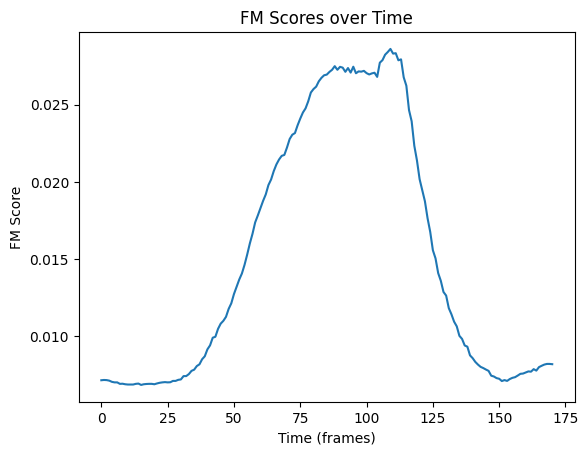

In [4]:
plt.plot(fm_scores)
plt.xlabel('Time (frames)')
plt.ylabel('FM Score')
plt.title('FM Scores over Time')
plt.show()

En el gráfico podemos observar que a partir del frame 50 el valor del score que mide la nitidez comienza a aumentar alcanzando un pico entre los valores  100 - 125, es decir entre estos tiempos la imagen está enfocada y luego comienza a disminuir hasta el final, lo que quiere decir que aumenta el grado de desefoque de toda la imagen. Es decir, la imagen en los tiempos de inicio y de final está desenfocada.

In [11]:
def plot_img(img):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 1, 1)
    plt.imshow(img)
    plt.axis('off')

    plt.show()

### 1.2 Medición sobre una ROI

In [12]:
def roi_grid(frame, grid_size=(8, 8), roi_size=20, color=(0, 0, 255)):
    output_image = frame.copy()
    spacing = 20

    total_grid_width = grid_size[1] * roi_size + (grid_size[1] - 1) * spacing
    total_grid_height = grid_size[0] * roi_size + (grid_size[0] - 1) * spacing

    img_height, img_width = frame.shape[:2]
    start_x = (img_width - total_grid_width) // 2
    start_y = (img_height - total_grid_height) // 2

    rois = []

    for row in range(grid_size[0]):
        for col in range(grid_size[1]):
            x = start_x + col * (roi_size + spacing)
            y = start_y + row * (roi_size + spacing)

            top_left = (x, y)
            bottom_right = (x + roi_size, y + roi_size)

            rois.append(frame[y:y + roi_size, x:x + roi_size])
            
            cv2.rectangle(output_image, top_left, bottom_right, color, 2)

    return rois, output_image

In [13]:
def get_video_writer(output_path, capture):
    width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(capture.get(cv2.CAP_PROP_FPS))
    codec = cv2.VideoWriter_fourcc(*'avc1')
    return cv2.VideoWriter(output_path, codec, fps, (width, height))

In [8]:
video_path = './data/focus_video.mov'
output_video_path = "./out/output_single_roi_video.mov"

cap = cv2.VideoCapture(video_path)
fm_scores = []

out = get_video_writer(output_video_path, cap)
focus_threshold = 2

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        # Single ROI, 6.25 % of image size ((120 * 120) / (360 * 640))
        rois, _ = roi_grid(frame, (1,1), 120, 2)
        score = image_sharpness(rois[0]) 
        fm_scores.append(score)
        _, colored_rois = roi_grid(frame, (1,1), 120, (0, 255, 0) if score >= focus_threshold else (0, 0, 255))
        out.write(colored_rois)

    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()

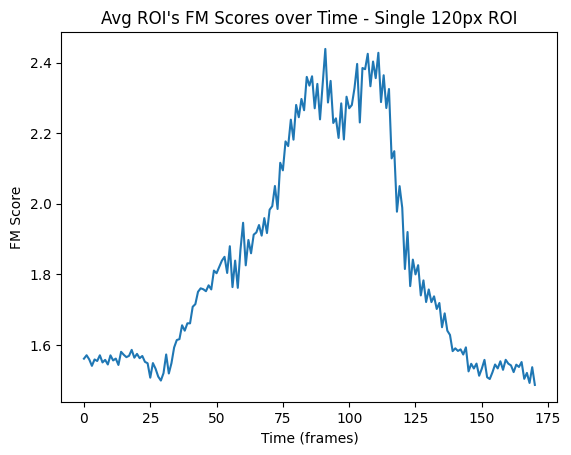

In [9]:
plt.plot(fm_scores)
plt.xlabel('Time (frames)')
plt.ylabel('FM Score')
plt.title('Avg ROI\'s FM Scores over Time - Single 120px ROI')
plt.show()

En este punto calculamos la métrica sobre un área específica. A partir del frame 25 comienza a aumentar el nivel de nitidez, entre el 50 y 75 hay dos picos en donde desciende y toma un valor menor a 1.8, luego continúa aumentando alcanzado un pico máximo un poco mayor a 2.4 entre los frames 75 y 100, finalmente entre 100 y 125 se observa un punto en donde empieza a disminuir hasta el final, es decir va tomando mayor grado de desenfoque.  

### 1.3 Medición sobre una matriz de enfoque

In [44]:
def score_grid(grid, size, threshold, output, score_method=image_sharpness, score_label='FM Score'):
    video_path = 'data/focus_video.mov'
    
    cap = cv2.VideoCapture(video_path)
    fm_scores = []
    
    out = get_video_writer(output, cap)
    
    while cap.isOpened():
        ret, frame = cap.read()
    
        if ret:
            # Default grid, 8x8 20px squares
            rois, _ = roi_grid(frame, grid, size)
            score = np.mean([score_method(roi) for roi in rois])
            fm_scores.append(score)
            _, colored_rois = roi_grid(frame, grid, size, (0, 255, 0) if score >= threshold else (0, 0, 255))
            out.write(colored_rois)
    
        else:
            break
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    
    plt.plot(fm_scores)
    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold (y = {threshold})')  # Add horizontal

    plt.xlabel('Time (frames)')
    plt.ylabel(f'{score_label}')
    plt.title(f'Avg ROI\'s {score_label} over Time - {grid} grid')
    plt.show()

Medición para los valores:

| size (nxm)   | threshold | 
|---|---|
| (3,3)        | 40  | 
| (6,6)  | 30  | 
| (5,10) |  20 | 
|  (9,9) |  20 | 


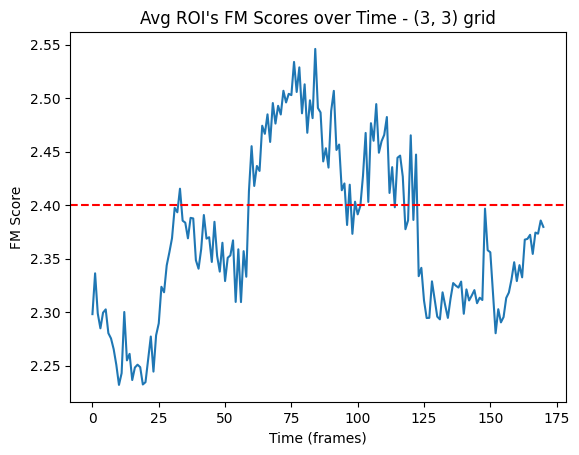

In [54]:
score_grid((3,3), 40, 2.4, "./out/output_3x3_roi_video.mov")

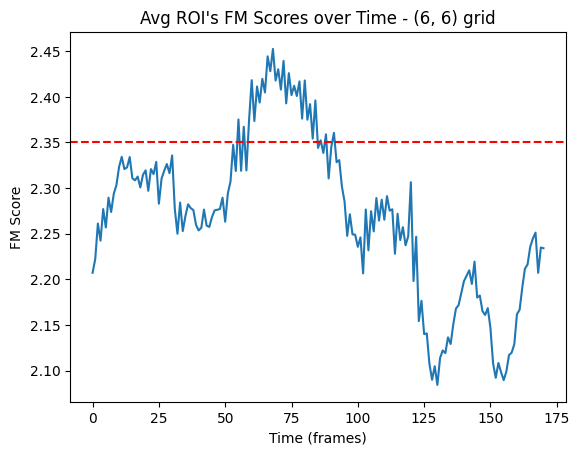

In [66]:
score_grid((6,6), 30, 2.35, "./out/output_6x6_roi_video.mov")

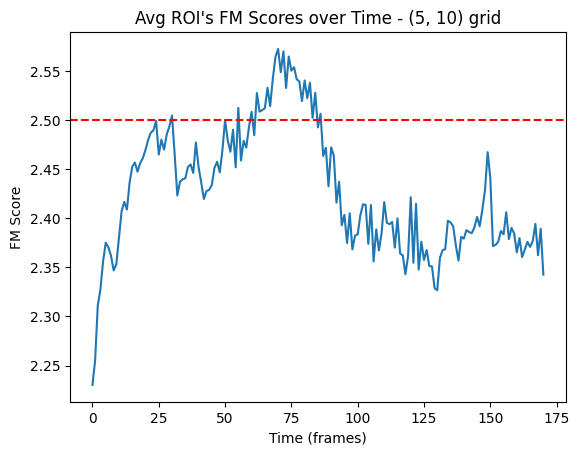

In [67]:
score_grid((5,10), 20, 2.5,"./out/output_5x10_roi_video.mov")

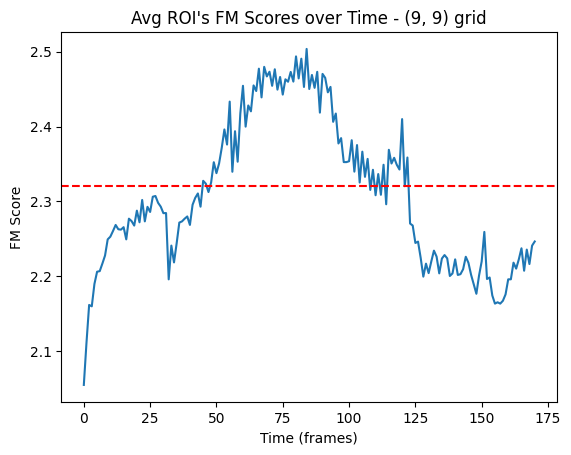

In [65]:
score_grid((9,9), 20, 2.32, "./out/output_9x9_roi_video.mov")

## 2.

Se implementa la función de enfoque de Tenengrad
![Tenengrad Formula](./files/tenengrad_formula.png)

Donde Gx y Gy son los gradientes en X e Y respectivamente.

Estos gradientes se calculan de forma aproximada con el operador de Sobel en X e Y. 
Luego se realiza la sumatoria para cada pixel de la suma de los gradientes al cuadrado

In [45]:
def tenengrad_score(frame):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    sobel_x = cv2.Sobel(gray_frame, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray_frame, cv2.CV_64F, 0, 1, ksize=3)
    square_gradient = np.sqrt(sobel_x**2 + sobel_y**2)
    
    return np.sum(square_gradient)

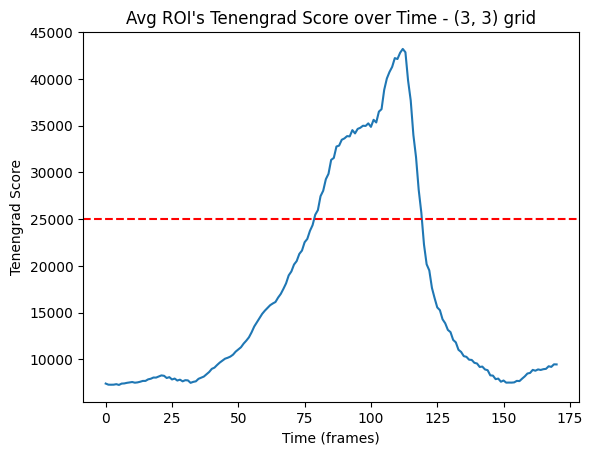

In [46]:
score_grid((3,3), 30, 25000, "./out/output_3x3_tenengrad_roi_video.mov", tenengrad_score, 'Tenengrad Score')

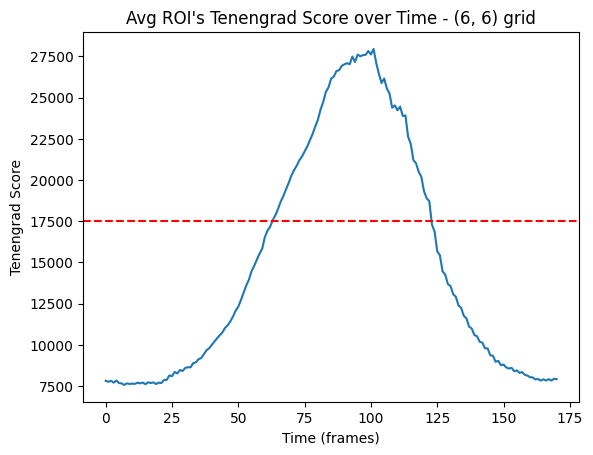

In [47]:
score_grid((6,6), 30, 17500, "./out/output_6x6_tenengrad_roi_video.mov", tenengrad_score, 'Tenengrad Score')

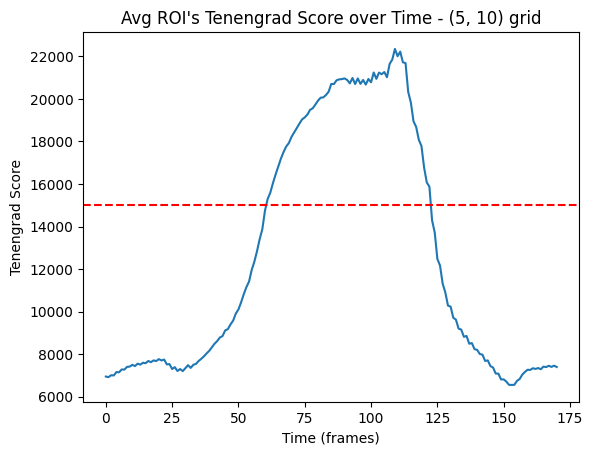

In [48]:
score_grid((5,10), 30, 15000, "./out/output_5x10_tenengrad_roi_video.mov", tenengrad_score, 'Tenengrad Score')

Para las 3 pruebas utilizando la métrica de Tenengrad se puede observar un claro pico en el valor del score. 

Este pico representa los frames en foco.

Cuanto mayor es el área cubierta por las distintas ROI, más precisa es la métrica y el tiempo durante el cual la métrica es mayor al threshold también es mayor.